# Metrics Comparison - Data Analysis

Dieses Notebook lädt TensorBoard‑Event‑Dateien mehrerer RL‑Trainingsläufe und erzeugt Vergleichsvisualisierungen für Training- und Evaluationsmetriken.


In [8]:
import os
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Log-Verzeichnisse definieren
runs = {
    'ppo_initial': "runs/ALE/SpaceInvaders-v5__initial__1__20250615_000342",
    'ppo_impala': "runs/ALE/SpaceInvaders-v5__impala__1__20250615_000632",
    'ppo_recurrent': "runs/ALE/SpaceInvaders-v5__ppo_recurrent__1__20250615_104736",
    'ppo_rnd': "runs/ALE/SpaceInvaders-v5__rnd__1__20250615_000809",
    'hp_optuna': "runs/ALE/SpaceInvaders-v5__hp-optuna__1__20250615_100646",
}

In [9]:
# 2. Funktion zum Laden aller Scalar-Tags aus einem Lauf
def load_scalars(log_dir):
    ea = event_accumulator.EventAccumulator(
        log_dir,
        size_guidance={event_accumulator.SCALARS: 0}
    )
    ea.Reload()
    scalars = ea.Tags().get('scalars', [])
    all_items = []
    for tag in scalars:
        for ev in ea.Scalars(tag):
            all_items.append({
                'step': ev.step,
                'wall_time': ev.wall_time,
                'tag': tag,
                'value': ev.value
            })
    return pd.DataFrame(all_items)

In [10]:
# 3. Daten aller Läufe laden und zusammenführen
df_list = []
for name, logdir in runs.items():
    print(f"Lade Run '{name}' aus: {logdir}")
    df_run = load_scalars(logdir)
    df_run['run'] = name
    df_list.append(df_run)
df_all = pd.concat(df_list, ignore_index=True)

Lade Run 'ppo_initial' aus: runs/ALE/SpaceInvaders-v5__initial__1__20250615_000342
Lade Run 'ppo_impala' aus: runs/ALE/SpaceInvaders-v5__impala__1__20250615_000632
Lade Run 'ppo_recurrent' aus: runs/ALE/SpaceInvaders-v5__ppo_recurrent__1__20250615_104736
Lade Run 'ppo_rnd' aus: runs/ALE/SpaceInvaders-v5__rnd__1__20250615_000809
Lade Run 'hp_optuna' aus: runs/ALE/SpaceInvaders-v5__hp-optuna__1__20250615_100646


In [11]:
# 4. Vergleichsplots für Training-Metriken
train_tags = [
    'train/episodic_return', 'charts/learning_rate', 'losses/value_loss',
    'losses/policy_loss', 'losses/entropy', 'losses/approx_kl',
    'losses/clipfrac', 'losses/explained_variance', 'charts/StepPerSecond'
]

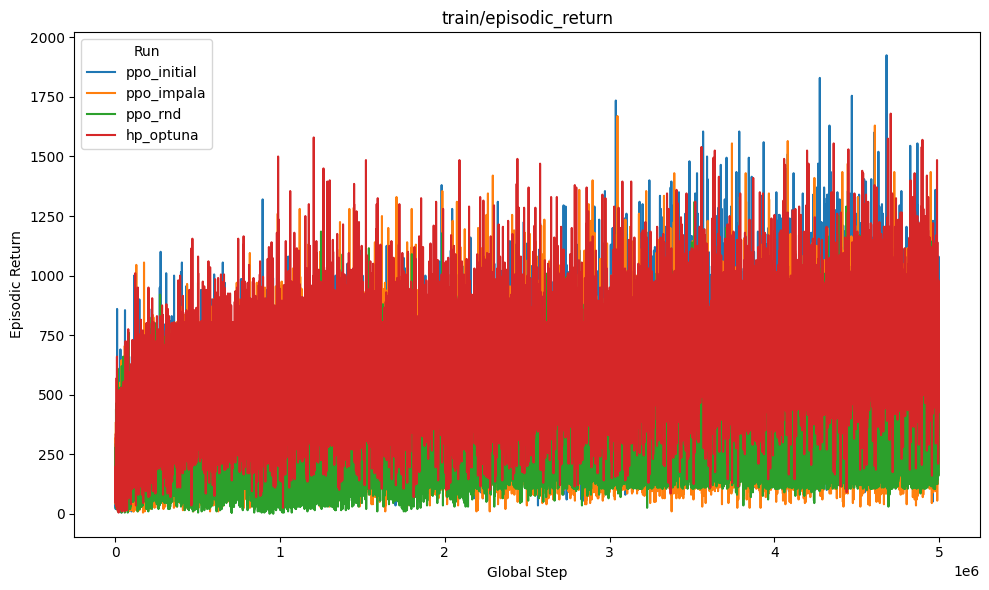

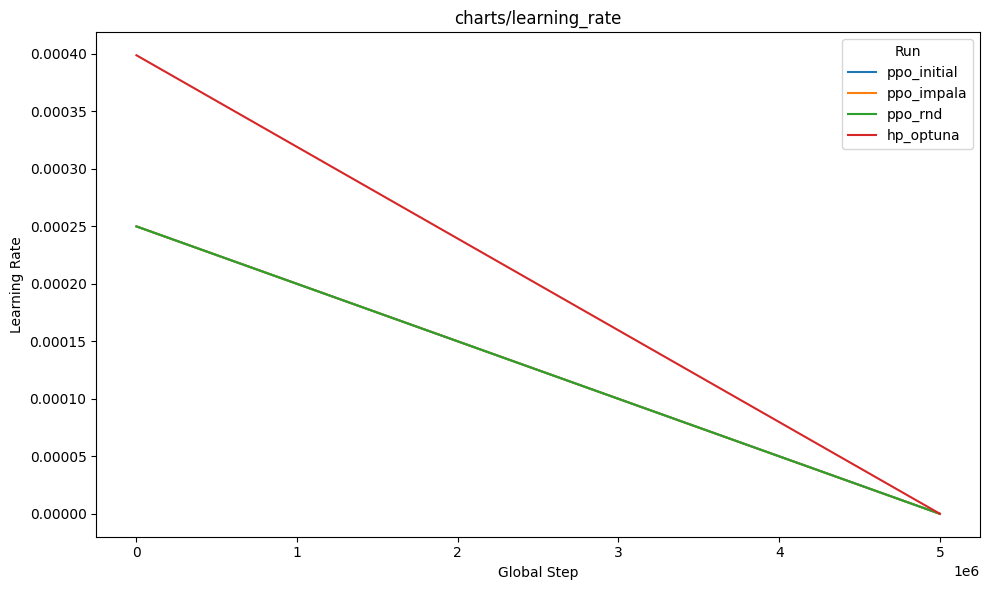

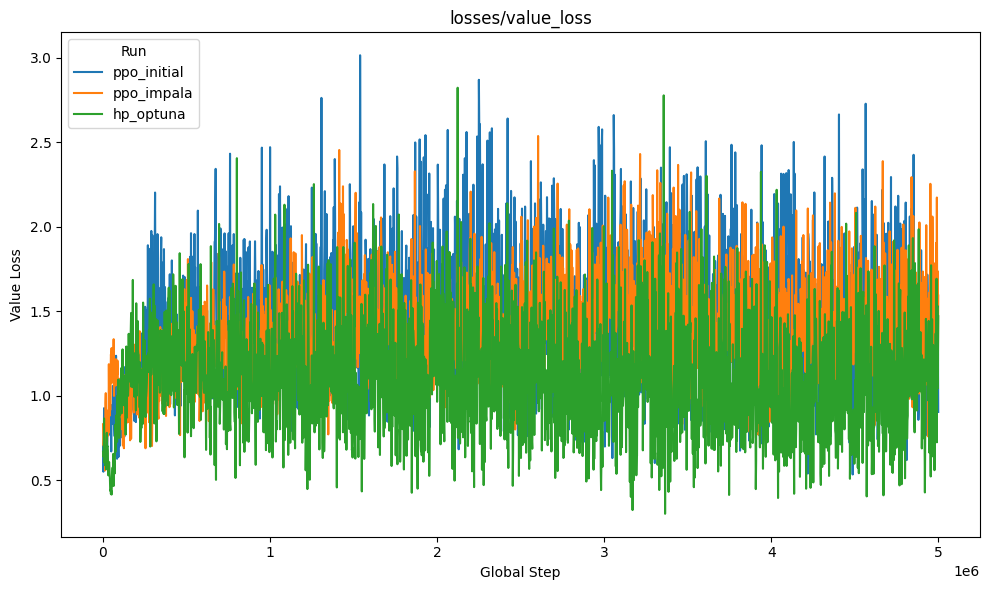

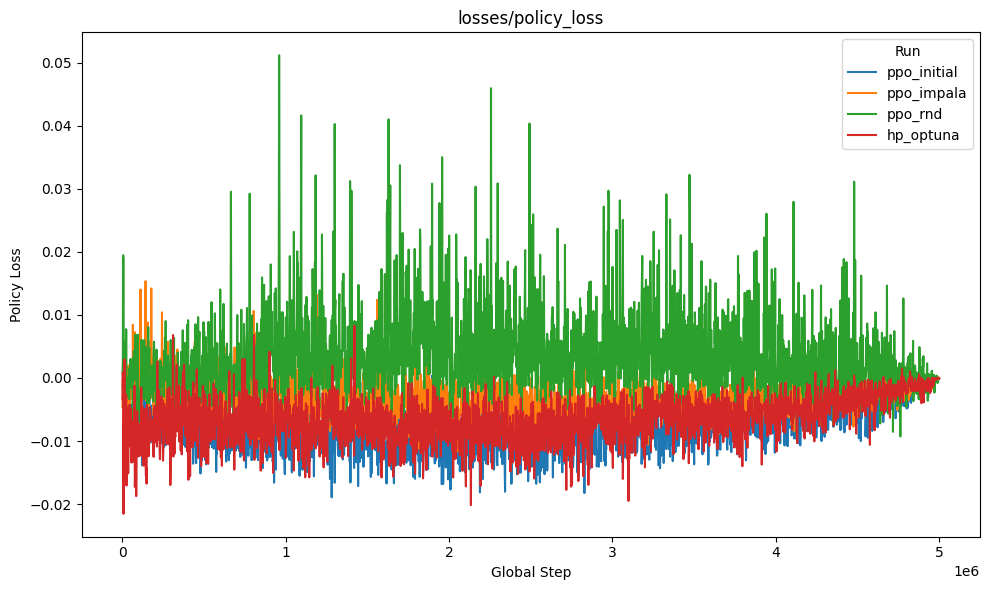

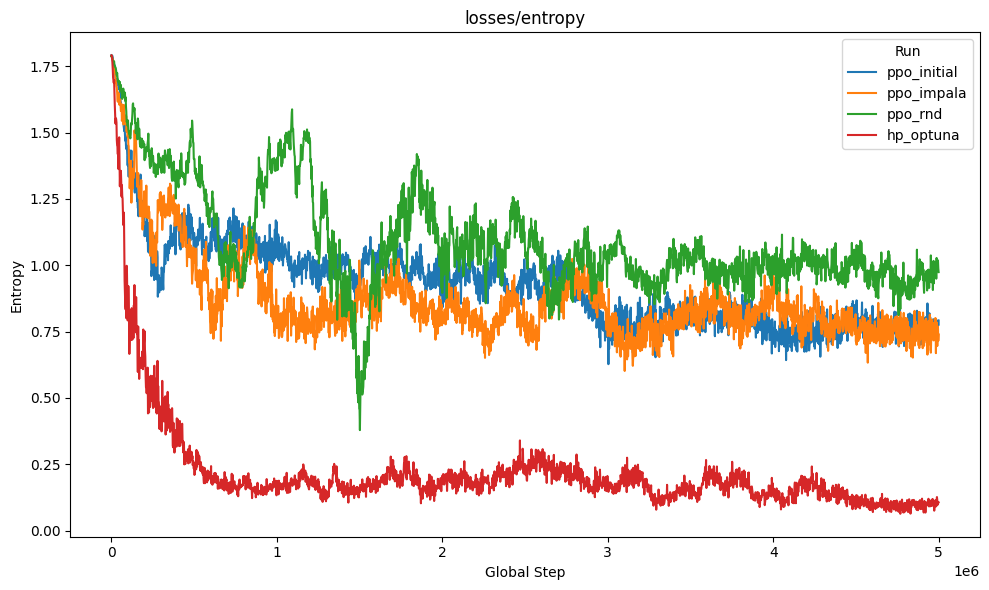

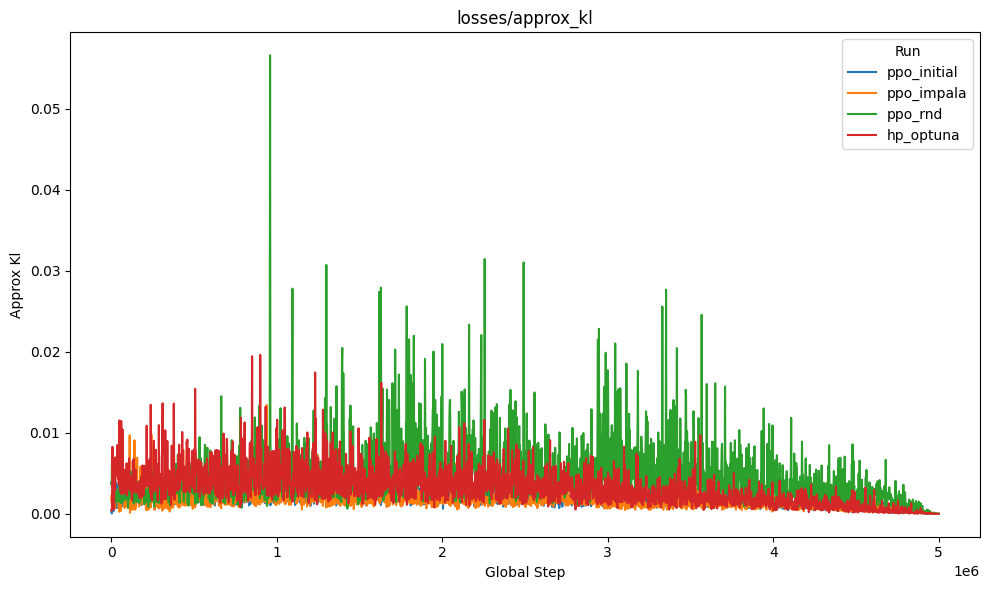

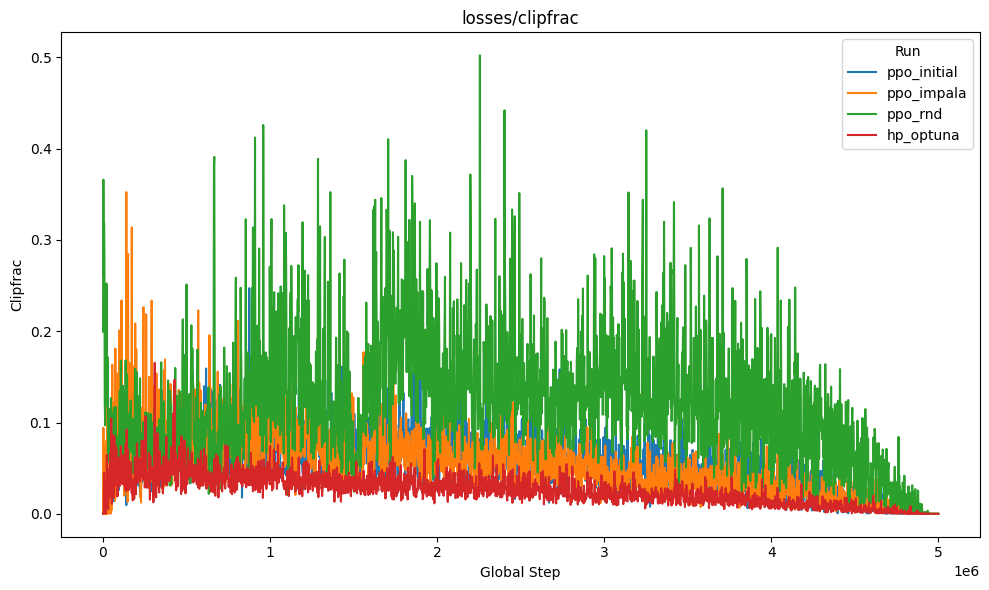

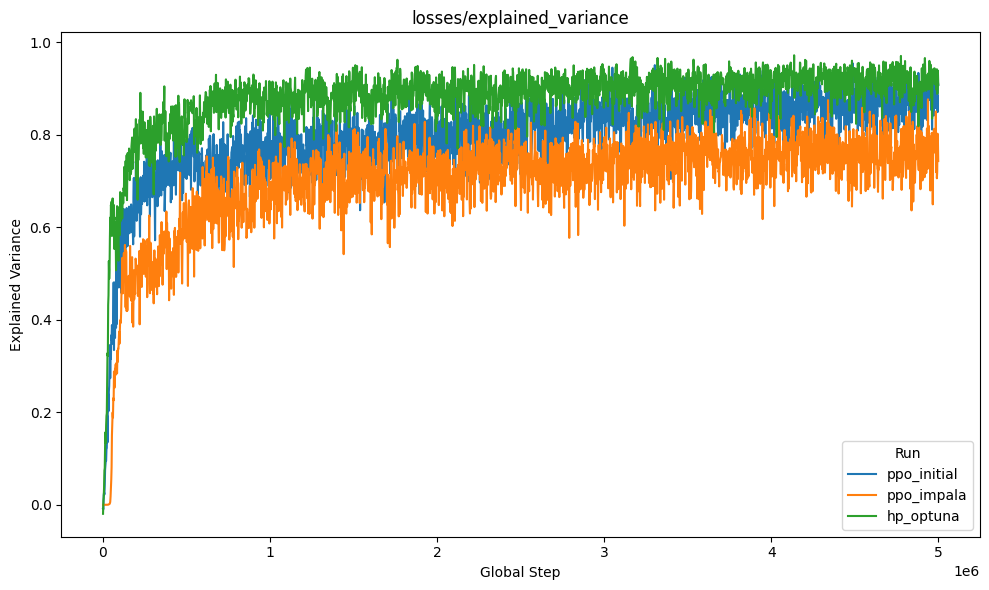

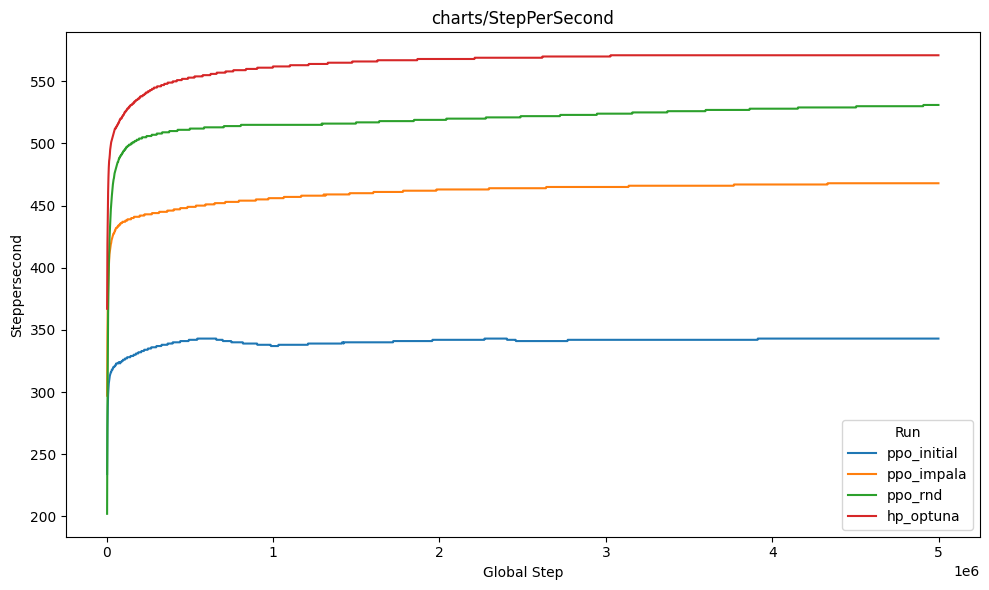

In [12]:
for tag in train_tags:
    if tag in df_all['tag'].unique():
        plt.figure(figsize=(10, 6))
        for run_name in runs.keys():
            subset = df_all[(df_all['tag'] == tag) & (df_all['run'] == run_name)]
            if subset.empty:
                continue
            subset = subset.sort_values('step')
            plt.plot(subset['step'], subset['value'], label=run_name)
        plt.title(tag)
        plt.xlabel('Global Step')
        plt.ylabel(tag.split('/')[-1].replace('_', ' ').title())
        plt.legend(title='Run')
        plt.tight_layout()
        plt.show()

C:\Users\flori\AppData\Local\Temp\ipykernel_24684\2037166734.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=runs.keys())


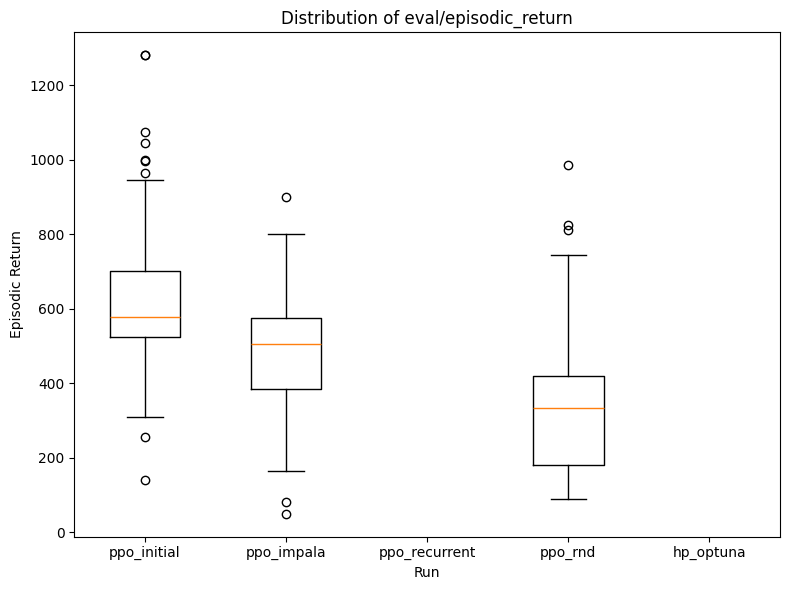

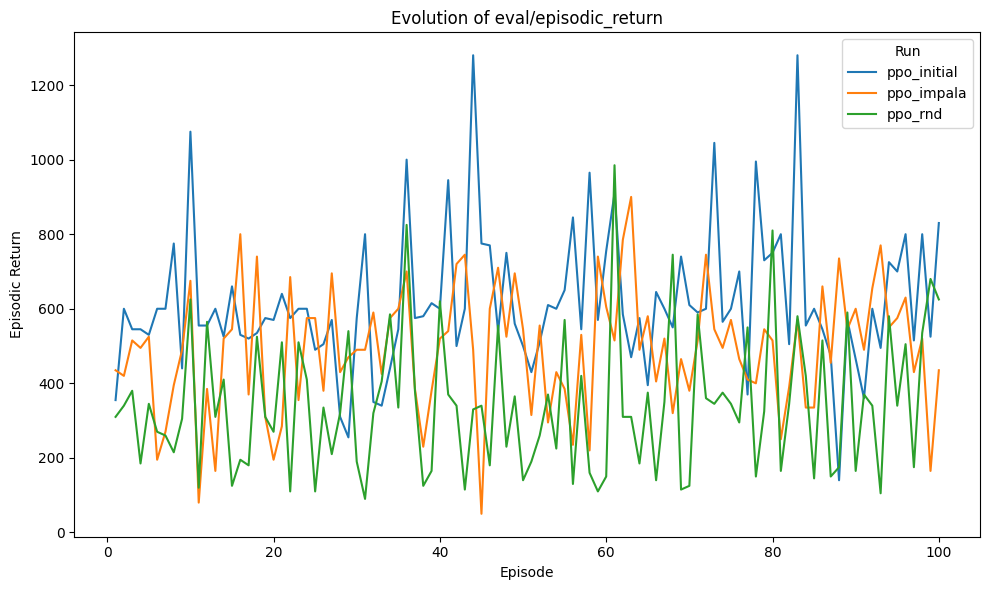

C:\Users\flori\AppData\Local\Temp\ipykernel_24684\2037166734.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=runs.keys())


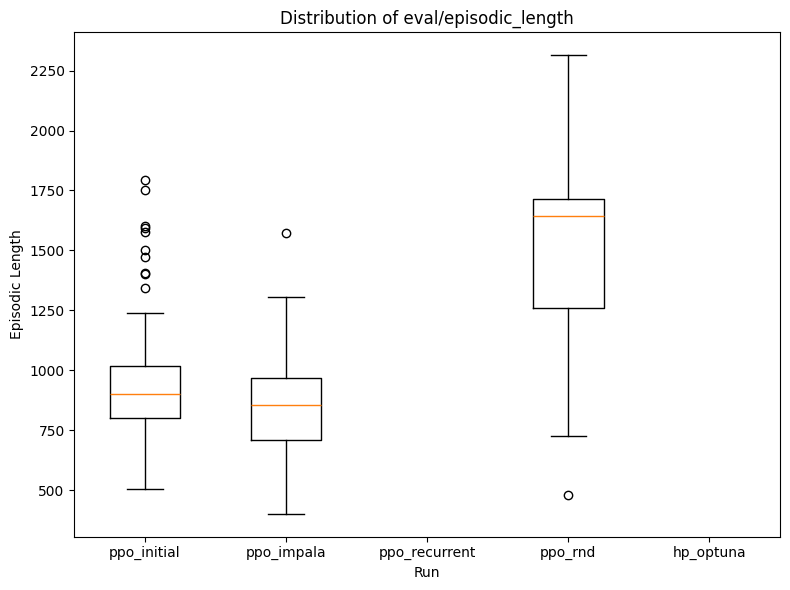

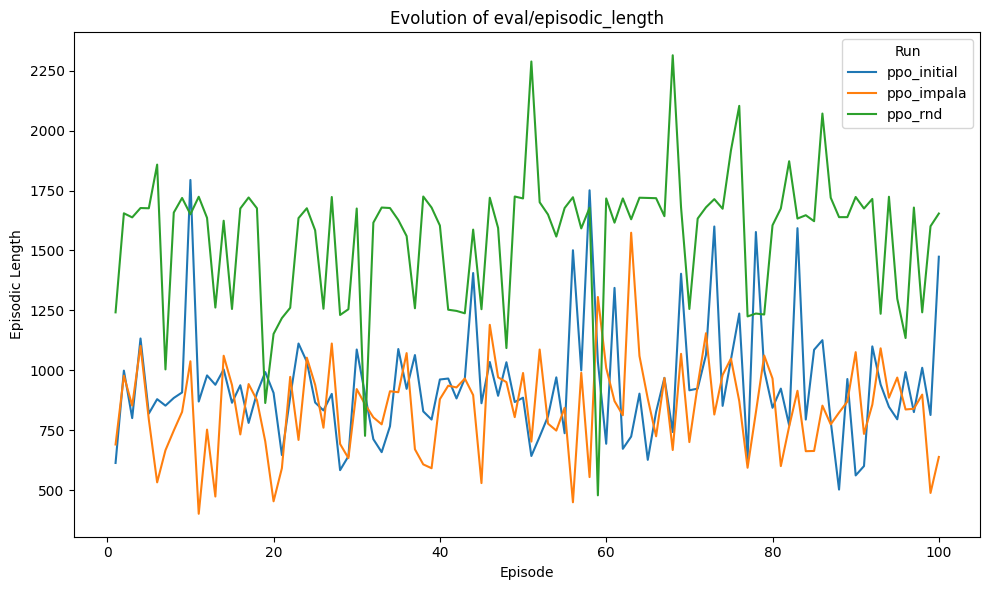

C:\Users\flori\AppData\Local\Temp\ipykernel_24684\2037166734.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=runs.keys())


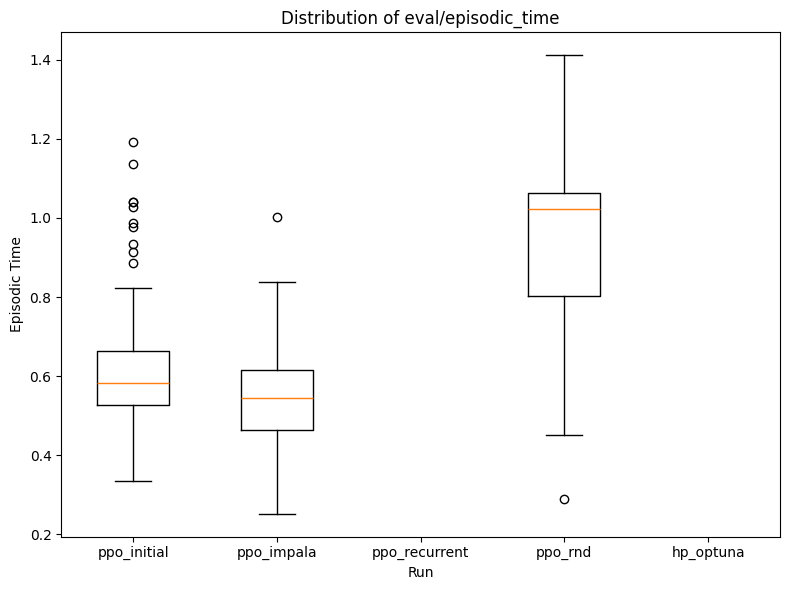

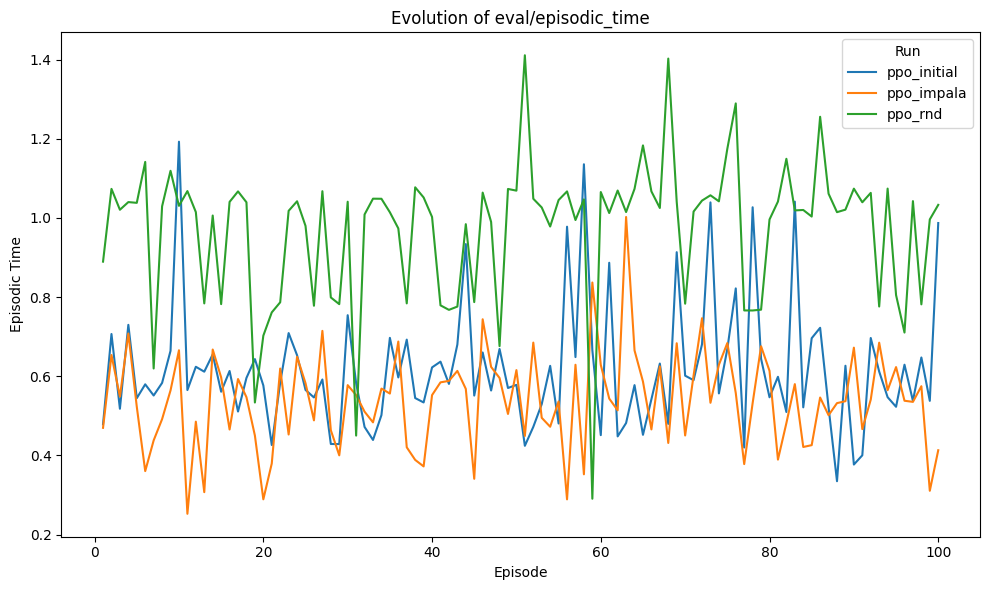

In [13]:
# 5. Vergleichsplots für Eval-Metriken
eval_tags = ['eval/episodic_return', 'eval/episodic_length', 'eval/episodic_time']

for tag in eval_tags:
    if tag in df_all['tag'].unique():
        # Boxplot über Runs
        plt.figure(figsize=(8, 6))
        data = [
            df_all[(df_all['tag'] == tag) & (df_all['run'] == run)]['value'].values
            for run in runs.keys()
        ]
        plt.boxplot(data, labels=runs.keys())
        plt.title(f'Distribution of {tag}')
        plt.ylabel(tag.split('/')[-1].replace('_', ' ').title())
        plt.xlabel('Run')
        plt.tight_layout()
        plt.show()

        # Linienplot: Verlauf pro Episode
        plt.figure(figsize=(10, 6))
        for run_name in runs.keys():
            subset = df_all[(df_all['tag'] == tag) & (df_all['run'] == run_name)].copy()
            if subset.empty:
                continue
            subset = subset.reset_index(drop=True)
            subset['episode'] = subset.index + 1
            plt.plot(subset['episode'], subset['value'], label=run_name)
        plt.title(f'Evolution of {tag}')
        plt.xlabel('Episode')
        plt.ylabel(tag.split('/')[-1].replace('_', ' ').title())
        plt.legend(title='Run')
        plt.tight_layout()
        plt.show()

C:\Users\flori\AppData\Local\Temp\ipykernel_24684\2820415478.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d.assign(segment=np.floor_divide(np.arange(len(d)), 100)))


<Figure size 1200x600 with 0 Axes>

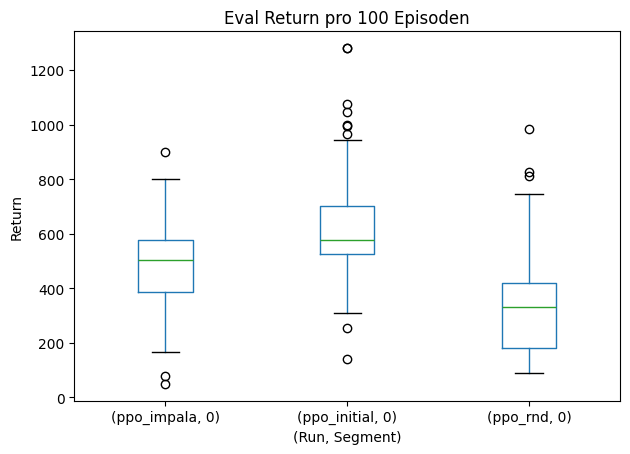

In [14]:
# 6. Gruppierte Boxplots: Eval Return pro 100 Episoden und Run
tag = 'eval/episodic_return'
if tag in df_all['tag'].unique():
    # Alle Segmentwerte in einer Tabelle
    df_segment = (
        df_all[df_all['tag'] == tag]
        .groupby('run')
        .apply(lambda d: d.assign(segment=np.floor_divide(np.arange(len(d)), 100)))
        .reset_index(drop=True)
    )

    plt.figure(figsize=(12, 6))
    # Boxplot mit MultiIndex: Run x Segment
    df_segment.boxplot(column='value', by=['run', 'segment'], grid=False)
    plt.suptitle('')
    plt.title('Eval Return pro 100 Episoden')
    plt.xlabel('(Run, Segment)')
    plt.ylabel('Return')
    plt.tight_layout()
    plt.show()
